In [ ]:
import pandas as pd
import json
import numpy as np
import ast

In [ ]:
with open('appraisals_dataset.json', 'r') as f:
  data = json.load(f)
  df = pd.DataFrame(data)
  display(df.head())

,appraisals
0,"{'orderID': '4762597', 'subject': {'address': ..."
1,"{'orderID': '4762739', 'subject': {'address': ..."
2,"{'orderID': '4763065', 'subject': {'address': ..."
3,"{'orderID': '4763086', 'subject': {'address': ..."
4,"{'orderID': '4763087', 'subject': {'address': ..."


In [ ]:
import pandas as pd

df = pd.json_normalize(df['appraisals'])
display(df.head())

,orderID,comps,properties,subject.address,subject.subject_city_province_zip,subject.effective_date,subject.municipality_district,subject.site_dimensions,subject.lot_size_sf,subject.units_sq_ft,...,subject.room_count,subject.num_beds,subject.room_total,subject.main_lvl_area,subject.second_lvl_area,subject.third_lvl_area,subject.gla,subject.subject_age,subject.num_baths,subject.condition
0,4762597,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',...",142-950 Oakview Ave Kingston ON K7M 6W8,"""Twin Oak Meadows""",Apr/11/2025,Kingston,Condo Common Property,n/a,SqFt,...,6,3,6,522,522,,1044,49,1:1,Average
1,4762739,"[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro...",7180 207 HWY Halifax NS B0J2L0,"West Chezzetcook, NS B0J2L0",Apr/17/2025,Halifax Regional Municipality - West Chezzetcook,See Schedule A and or Plot Map,72745+/-SqFt,SqFt,...,6,3,6,1060,440,,1500 SqFt,14+/-yrs,2:1,Average
2,4763065,"[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan...",11 PAUL AVE Ayr ON N0B1E0,Ayr ON N0B1E0,May/01/2025,"Township of North Dumfries, Region of Waterloo",131' x 154',20174 SqFt,SqFt,...,9,4,9,1660,1340,,3000 SqFt,42,2:1,Average
3,4763086,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ...",102 Stonewalk Dr Kemptville ON K0G 1J0,Kemptville ON K0G 1J0,Apr/15/2025,"North Grenville, Ontario",176.38 F x Irregular,1.25 Acres,Acres,...,5,2,5,,,,1283 SqFt,2012 +/-,3:0,Good
4,4763087,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '...",407 105 Dunbrack St Halifax NS B3M3G7,Halifax NS B3M3G7,Apr/17/2025,Halifax Regional Municipality - Halifax,CONDO - N/A,N/A,N/A,...,6,3,6,1530,,,1530 SqFt,47+/-yrs,2:0,Average


In [ ]:
# Check the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display data types of each column
print("\nData Types:")
print(df.dtypes)

# Identify missing values
print("\nMissing Values:")
print(df.isnull().sum())

#Property example
print("\nProperty Example:")
print(df['properties'][0])

# Display the first few rows
print("\nFirst few rows:")
display(df.head())

for col in df.select_dtypes(exclude=['number']):
    print(f"\nUnique values and frequencies for column '{col}':")
    print(df[col].value_counts())


In [ ]:
all_properties = []

for _, row in df.iterrows():
    subject_id = row['orderID']
    subject = row['subject.address']
    for prop in row['properties']:
        prop['orderID'] = subject_id
        prop['subject_address'] = subject
        all_properties.append(prop)

properties_df = pd.DataFrame(all_properties)
properties_df.head()

,id,address,bedrooms,gla,city,province,postal_code,property_sub_type,structure_type,style,...,basement,cooling,heating,close_price,close_date,public_remarks,latitude,longitude,orderID,subject_address
0,367,463 Conservatory Dr,3.0,1500.0,Kingston,Ontario,K7M 9C8,Detached,Detached,"Brick, Vinyl Siding",...,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,4762597,142-950 Oakview Ave Kingston ON K7M 6W8
1,163443,463 Conservatory Drive,3.0,1750.0,Kingston,Ontario,K7M 9C8,Detached,"Detached, 2-Storey",2-Storey,...,Unfinished,Central Air,Forced Air,674000.0,2025-01-13,Welcome to this beautifully maintained and spa...,44.2325,-76.5901,4762597,142-950 Oakview Ave Kingston ON K7M 6W8
2,378,311 Janette St,3.0,1500.0,Kingston,Ontario,K7P 0K8,Freehold Townhouse,Freehold Townhouse,2-Storey,...,Fin W/O,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,4762597,142-950 Oakview Ave Kingston ON K7M 6W8
3,130023,311 Janette Street,3.0,1300.0,Kingston,Ontario,K7P 0K8,Freehold Townhouse,"Freehold Townhouse, 2-Storey",2-Storey,...,Finished with Walk-Out,Central Air,Forced Air,585000.0,2025-01-14,"Come and see what this fully finished, Barr co...",44.2622,-76.5904,4762597,142-950 Oakview Ave Kingston ON K7M 6W8
4,2782,4056 Bath Rd,4.0,NaN,Kingston,Ontario,K7M 4Y4,Rural Resid,Rural Resid,2-Storey,...,"Part Bsmt, Unfinished",None,Baseboard,685000.0,2025-01-15,"Current valuation for 4056 Bath Rd, South of T...",44.2407,-76.6102,4762597,142-950 Oakview Ave Kingston ON K7M 6W8


In [ ]:
print(properties_df.columns)

Index(['id', 'address', 'bedrooms', 'gla', 'city', 'province', 'postal_code',
       'property_sub_type', 'structure_type', 'style', 'levels', 'room_count',
       'full_baths', 'half_baths', 'main_level_finished_area',
       'upper_lvl_fin_area', 'bg_fin_area', 'lot_size_sf', 'year_built',
       'roof', 'basement', 'cooling', 'heating', 'close_price', 'close_date',
       'public_remarks', 'latitude', 'longitude', 'orderID',
       'subject_address'],
      dtype='object')


In [ ]:
def parse_sqft(value):
    if isinstance(value, str):
        return float(value.replace(' SqFt', '').replace(',', '').strip())
    return value

properties_df['gla'] = properties_df['gla'].apply(parse_sqft)
properties_df['lot_size_sf'] = properties_df['lot_size_sf'].apply(parse_sqft)

def parse_baths(val):
    if isinstance(val, str) and ':' in val:
        full, half = map(int, val.split(':'))
        return full + 0.5 * half
    try:
        return float(val)
    except:
        return None

properties_df['half_baths'] = properties_df['half_baths'].apply(parse_baths)
properties_df['full_baths'] = properties_df['full_baths'].apply(parse_baths)

In [ ]:
def clean_and_prepare_properties(properties):
    """
    Cleans and encodes property data for clustering.
    Input: list of dicts (property features)
    Output: cleaned pandas DataFrame
    """

    numeric_features = [
        "gla", "bedrooms", "full_baths", "half_baths",
        "lot_size_sf", "garage_spaces", "year_built"
    ]

    categorical_features = [
        "structure_type", "style", "basement",
        "heating", "cooling", "garage_type"
    ]

    processed_rows = []

    for prop in properties:
        row = {}
        try:
            for num_feat in numeric_features:
                val = prop.get(num_feat)
                row[num_feat] = float(val) if val is not None else np.nan

            for cat_feat in categorical_features:
                val = prop.get(cat_feat)
                row[cat_feat] = (
                    str(val).strip().lower() if val is not None else "unknown"
                )

            processed_rows.append(row)

        except Exception as e:
            print(f"Skipping property due to error: {e}")
            continue

    df = pd.DataFrame(processed_rows)
    for col in numeric_features:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    return df_encoded

properties_list = properties_df.to_dict(orient="records")
cleaned_df = clean_and_prepare_properties(properties_list)

print(cleaned_df.head())

      gla  bedrooms  full_baths  half_baths  lot_size_sf  garage_spaces  \
0  1500.0       3.0         3.0         1.0       3555.5            NaN   
1  1750.0       3.0         2.0         1.0       3535.0            NaN   
2  1500.0       3.0         4.0         1.0       2622.0            NaN   
3  1300.0       3.0         2.0         1.0       2622.0            NaN   
4  1300.0       4.0         4.0         0.0      16672.0            NaN   

   year_built  structure_type_4 plex  structure_type_apartment  \
0      2004.0                  False                     False   
1      2004.0                  False                     False   
2      2004.0                  False                     False   
3      2004.0                  False                     False   
4      2004.0                  False                     False   

   structure_type_apartment, one level  ...  \
0                                False  ...   
1                                False  ...   
2          

In [ ]:
properties_list = properties_df.to_dict(orient="records")

cleaned_df = clean_and_prepare_properties(properties_list)

print(cleaned_df.head())

      gla  bedrooms  full_baths  half_baths  lot_size_sf  garage_spaces  \
0  1500.0       3.0         3.0         1.0       3555.5            NaN   
1  1750.0       3.0         2.0         1.0       3535.0            NaN   
2  1500.0       3.0         4.0         1.0       2622.0            NaN   
3  1300.0       3.0         2.0         1.0       2622.0            NaN   
4  1300.0       4.0         4.0         0.0      16672.0            NaN   

   year_built  structure_type_4 plex  structure_type_apartment  \
0      2004.0                  False                     False   
1      2004.0                  False                     False   
2      2004.0                  False                     False   
3      2004.0                  False                     False   
4      2004.0                  False                     False   

   structure_type_apartment, one level  ...  \
0                                False  ...   
1                                False  ...   
2          

In [ ]:
from sklearn.preprocessing import StandardScaler

print("NaNs per column:\n", cleaned_df.isna().sum().sort_values(ascending=False).head(10))

numerical_cols = ['gla', 'bedrooms', 'full_baths', 'half_baths', 'lot_size_sf', 'garage_spaces', 'year_built']
for col in numerical_cols:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

bool_cols = cleaned_df.select_dtypes(include=['bool']).columns
cleaned_df[bool_cols] = cleaned_df[bool_cols].fillna(False)

scaler = StandardScaler()
cleaned_df[numerical_cols] = scaler.fit_transform(cleaned_df[numerical_cols])

variance = cleaned_df.var().sort_values()
print("Lowest variance features:\n", variance.head(10))

low_variance_features = variance[variance < 0.01].index
print(f"Removing {len(low_variance_features)} low variance features")
cleaned_df = cleaned_df.drop(columns=low_variance_features)

print("Shape after dropping low variance features:", cleaned_df.shape)

NaNs per column:
 garage_spaces                                      9820
heating_forced air, ducted cooling                    0
heating_forced air, fireplace                         0
heating_forced air, fireplace, in floor               0
heating_forced air, gravity, see remarks              0
heating_forced air, heat pump                         0
heating_forced air, heat pump, ducted cooling         0
heating_forced air, heat pump, ductless cooling       0
heating_forced air, heat pump, fireplace              0
heating_forced air, hot water                         0
dtype: int64
Lowest variance features:
 heating_electric,  forced air                                                                      0.000102
cooling_heat pump, hot water, fireplace                                                            0.000102
structure_type_detached, agriculture, bungalow                                                     0.000102
cooling_heat pump, hot water, fireplace, ductless cooling 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['garage_spaces']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


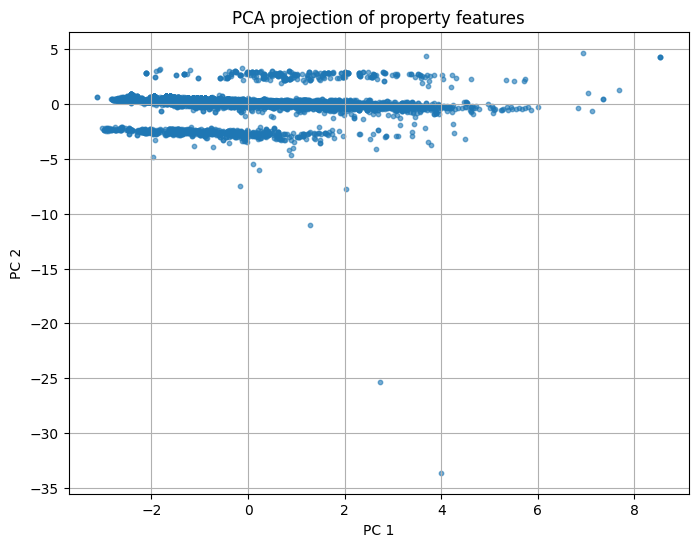

Explained variance by PC1 and PC2: 0.3880413667114185


In [ ]:
imputer = SimpleImputer(strategy='mean')
cleaned_imputed = imputer.fit_transform(cleaned_df)

pca = PCA(n_components=2)
components = pca.fit_transform(cleaned_imputed)

plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], s=10, alpha=0.6)
plt.title('PCA projection of property features')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_.sum())


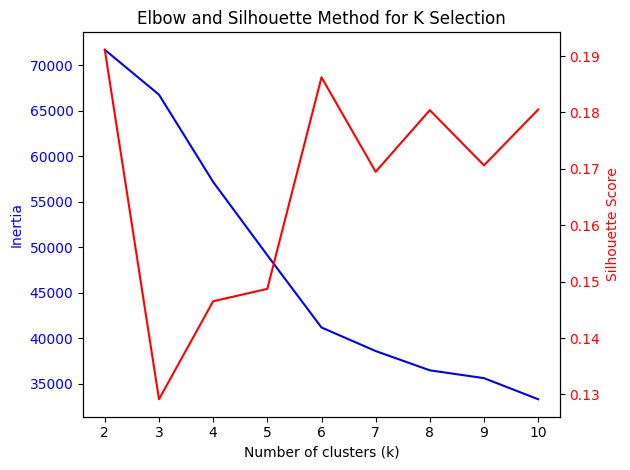

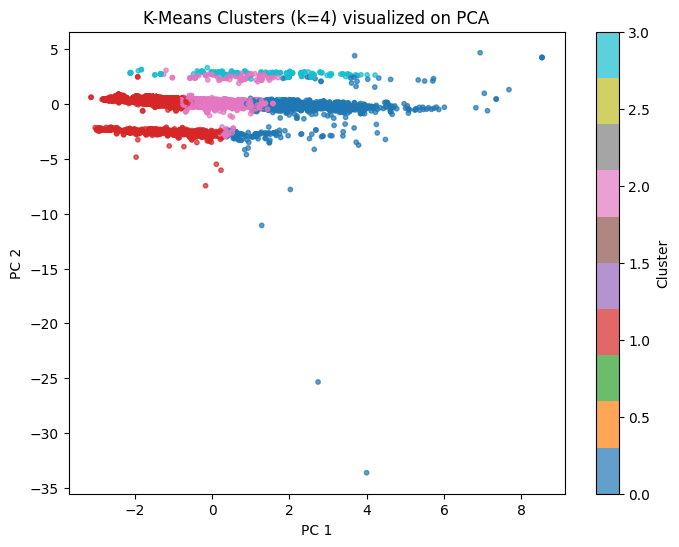

In [ ]:
inertia = []
silhouette = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cleaned_imputed)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette.append(silhouette_score(cleaned_imputed, labels))

fig, ax1 = plt.subplots()

ax1.plot(K, inertia, 'b-', label='Inertia (Sum of Squared Distances)')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(K, silhouette, 'r-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Elbow and Silhouette Method for K Selection')
fig.tight_layout()
plt.show()

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(cleaned_imputed)

plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.7)
plt.title(f'K-Means Clusters (k={k}) visualized on PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
first_row = df.iloc[0]
subject_data = {col.replace('subject.', ''): first_row[col] for col in df.columns if col.startswith('subject.')}

print("Subject Property:")
for key, value in subject_data.items():
    print(f"{key}: {value}")

# Extract candidate properties (stored as list of dicts)
# If it's a stringified list, use ast.literal_eval
if isinstance(first_row['properties'], str):
    candidate_properties = ast.literal_eval(first_row['properties'])
else:
    candidate_properties = first_row['properties']

print(f"\nFound {len(candidate_properties)} candidate properties.")
print("\nFirst 2 candidate properties:")
for i, prop in enumerate(candidate_properties[:2]):
    for key, value in prop.items():
        print(f"{key}: {value}")
    print("---")

Subject Property:
address: 142-950 Oakview Ave Kingston ON K7M 6W8
subject_city_province_zip: "Twin Oak Meadows"
effective_date: Apr/11/2025
municipality_district: Kingston
site_dimensions: Condo Common Property
lot_size_sf: n/a
units_sq_ft: SqFt
year_built: 1976
structure_type: Townhouse
roofing: Asphalt Shingle
effective_age: 25
style: 2 Storey
construction: Wood Frame
remaining_economic_life: 50
windows: Vinyl
basement: Full/Finished
exterior_finish: Brick Veneer, Vinyl Siding
basement_area: 522
foundation_walls: Concrete
flooring: Hardwood, carpet, laminate, ceramic
plumbing_lines: Copper, PEX, ABS
heating: Forced Air
fuel_type: Natural Gas
water_heater: 40 Gallon - Gas
cooling: Central Air
room_count: 6
num_beds: 3
room_total: 6
main_lvl_area: 522
second_lvl_area: 522
third_lvl_area: 
gla: 1044
subject_age: 49
num_baths: 1:1
condition: Average

Found 146 candidate properties.

First 2 candidate properties:
id: 367
address: 463 Conservatory Dr
bedrooms: 3
gla: 1500
city: Kingston
p